<a href="https://colab.research.google.com/github/utsav972/Computer-Vision-Matarials/blob/main/deyectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15860, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 15860 (delta 38), reused 15 (delta 13), pack-reused 15783 (from 3)
Receiving objects: 100% (15860/15860), 6.41 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (11541/11541), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YIqpe59XxIGhiRKcgPfu")
project = rf.workspace("utsav-fpjwy").project("car-defect-detection-nfjfw-3wv58")
version = project.version(1)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Car-defect-detection-1 in coco:: 100%|██████████| 1076/1076 [00:00<00:00, 4885.35it/s]


In [12]:
register_coco_instances(
    "train",
    {},
    "/content/Car-defect-detection-1/train/_annotations.coco.json",
    "/content/Car-defect-detection-1/train"
)
register_coco_instances(
    "valid",
    {},
    "/content/Car-defect-detection-1/valid/_annotations.coco.json",
    "/content/Car-defect-detection-1/valid"
)

WARNING [04/29 21:35:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 21:35:32 d2.data.datasets.coco]: Loaded 917 images in COCO format from /content/Car-defect-detection-1/train/_annotations.coco.json


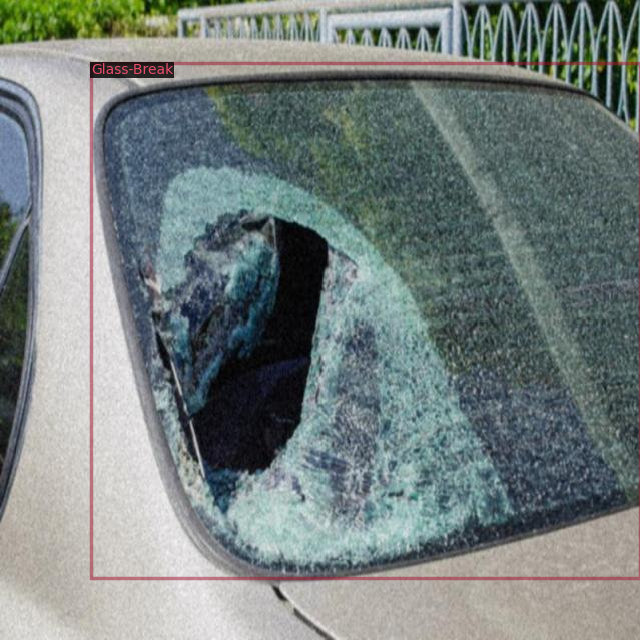

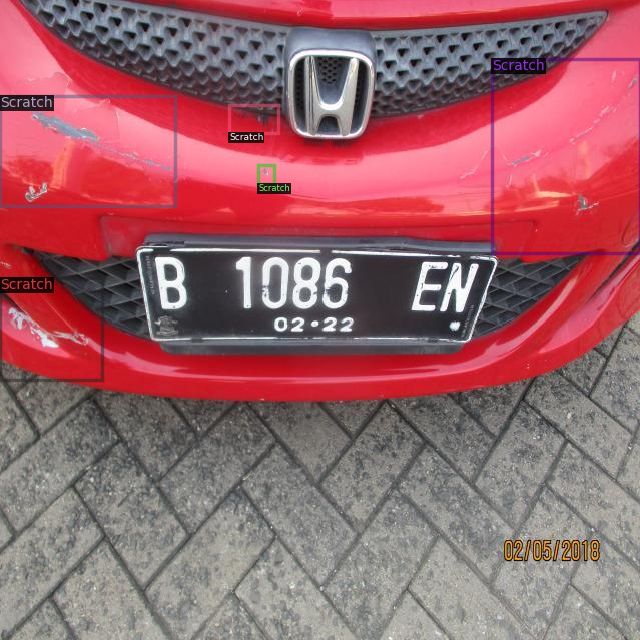

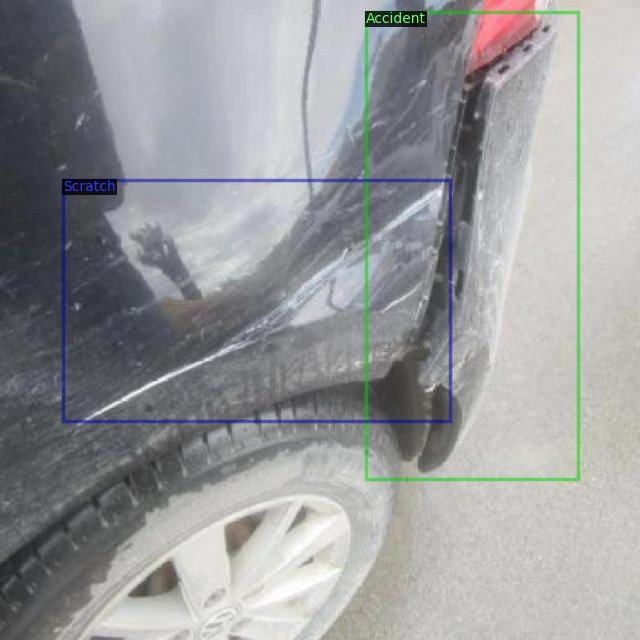

In [13]:
dataset_dicts = DatasetCatalog.get("train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train"))
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])



WARNING [04/29 21:36:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/29 21:36:29 d2.data.datasets.coco]: Loaded 917 images in COCO format from /content/Car-defect-detection-1/train/_annotations.coco.json


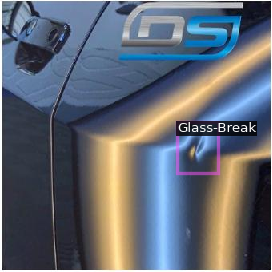

Image path: /content/Car-defect-detection-1/train/images-75-_png.rf.fcaffa64f87257e8e451f3ea71d31cef.jpg
Annotations: [{'iscrowd': 0, 'bbox': [221, 153, 51.5, 64], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]


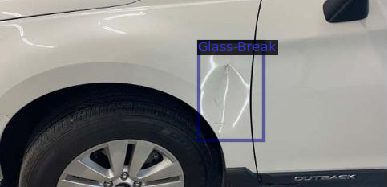

Image path: /content/Car-defect-detection-1/train/images-12-_png.rf.639502f9e121e2db9c1dd22353c08768.jpg
Annotations: [{'iscrowd': 0, 'bbox': [247, 51, 81.43, 124.64], 'category_id': 2, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]


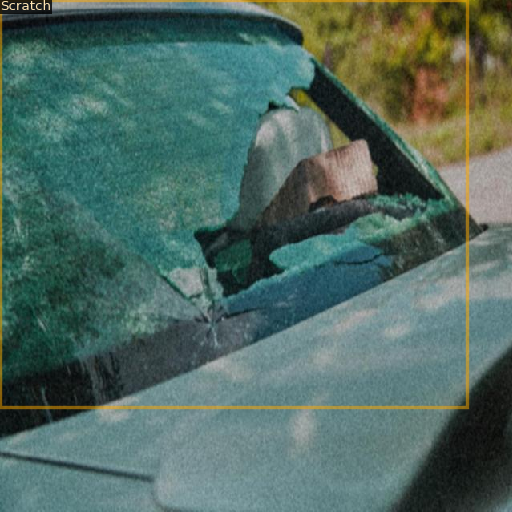

Image path: /content/Car-defect-detection-1/train/8223_jpg.rf.731dea16818d5bc0a91cc268a3c817d4.jpg
Annotations: [{'iscrowd': 0, 'bbox': [0, 0, 584, 509], 'category_id': 3, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]


In [14]:
# Visualize 3 random training samples
dataset_dicts = DatasetCatalog.get("train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
    print("Image path:", d["file_name"])
    print("Annotations:", d["annotations"])

In [16]:
# %% [Model Configuration]
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))

# Dataset configuration
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")

# Hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.2
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# Model architecture
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names)
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512]]
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 2000
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 1000

# Input configuration
cfg.INPUT.MIN_SIZE_TRAIN = (1024,)
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.CROP.ENABLED = True
cfg.INPUT.CROP.TYPE = "absolute"
cfg.INPUT.CROP.SIZE = (800, 800)

In [ ]:
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# %% [Training]
from detectron2.engine import DefaultTrainer, DefaultPredictor
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[04/29 21:39:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:06, 67.6MB/s]                          
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/29 21:39:20 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


[04/29 21:40:30 d2.utils.events]:  eta: 1:48:03  iter: 19  total_loss: 3.022  loss_cls: 1.78  loss_box_reg: 0.01654  loss_rpn_cls: 0.7057  loss_rpn_loc: 0.5141    time: 3.3583  last_time: 3.3936  data_time: 0.0382  last_data_time: 0.0262   lr: 1.1953e-06  max_mem: 13108M
[04/29 21:41:52 d2.utils.events]:  eta: 1:55:58  iter: 39  total_loss: 2.917  loss_cls: 1.66  loss_box_reg: 0.009375  loss_rpn_cls: 0.7142  loss_rpn_loc: 0.5494    time: 3.6503  last_time: 3.6526  data_time: 0.0382  last_data_time: 0.0259   lr: 2.1902e-06  max_mem: 13108M
[04/29 21:43:09 d2.utils.events]:  eta: 1:58:05  iter: 59  total_loss: 2.703  loss_cls: 1.446  loss_box_reg: 0.02064  loss_rpn_cls: 0.7061  loss_rpn_loc: 0.5181    time: 3.7195  last_time: 3.6600  data_time: 0.0344  last_data_time: 0.0103   lr: 3.1853e-06  max_mem: 13108M
[04/29 21:44:24 d2.utils.events]:  eta: 1:57:08  iter: 79  total_loss: 2.425  loss_cls: 1.203  loss_box_reg: 0.02394  loss_rpn_cls: 0.6992  loss_rpn_loc: 0.4675    time: 3.7283  last

In [ ]:
test_images = [f for f in os.listdir(f"{dataset.location}/test") if f.endswith(".jpg")]
for img_name in random.sample(test_images, 2):
    img_path = os.path.join(f"{dataset.location}/test", img_name)

    # Verify image loading
    if not os.path.exists(img_path):
        print(f"Missing image: {img_path}")
        continue

    im = cv2.imread(img_path)
    if im is None:
        print(f"Failed to load image: {img_path}")
        continue

In [ ]:
# %% [Evaluation]
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("valid", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "valid")
results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(results)


In [ ]:
outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    print(f"Predictions for {img_name}:")
    cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
    scores = outputs["instances"].scores.tolist()
    classes = outputs["instances"].pred_classes.tolist()
    for score, cls in zip(scores, classes):
        print(f"{metadata.thing_classes[cls]}: {score:.2f}")


In [ ]:

# %% [Save Model to Drive]
drive.mount('/content/drive')
!cp -r /content/output "/content/drive/MyDrive/car_defect_model"